#### I think it would be easier to copy Francesco get_initial_code in cpymad format and then just change the twiss at that particular spot

In [1]:
# imports
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
from IPython.core.display import display, HTML, Markdown
from cpymad.madx import Madx
%matplotlib notebook

In [2]:
madx = Madx(command_log="commandlog") #Writes the errors in this file once madx has quit
madx.option(verbose=False, debug=False, echo=False, warn=False, twiss_print=False) #Hides the output in the terminal

# Call latice files
madx.call("ps_repo/ps_mu.seq")
madx.call("ps_repo/ps_ss.seq")
madx.call("ps_lhc_repo/ps_ext_lhc.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls/ps_extraction/ps_ext_elements/fringe_field_fix.madx")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls/ps_extraction/ps_ext_elements/ft16.ele")


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.06.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2020.09.01               +
  + Execution date: 2021.07.23 15:54:43      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [3]:
madx.set(format="22.10e") # Je crois que c'est 22 chiffres en tout dont 10 derriere la decimal

True

In [4]:
#Beam
madx.command.beam(particle='PROTON',pc="26",exn="3.5e-6",eyn="3.5E-6")
madx.input('BRHO      := BEAM->PC * 3.3356;')

True

In [5]:
madx.use(sequence="PS")
twiss = madx.twiss()

Make extraction sequence to get to where there
is the handover with TT2

In [6]:
# Nominal kick strength for KFA71 for nTOF => assumed the same for AD and LHC
madx.input('kfa71_nom_kick = -1.15e-03;')

madx.input('ksmh16_error = -29.4e-3;')

madx.input('kPEKFA71 := kfa71_k;')
madx.input('kPIKFA45 := kfa45_kick ;')
madx.input('kPIKFA28 := kfa28_kick ;')

madx.input('SEQEDIT, sequence=PS;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.use(sequence = "PS")

In [7]:
#Cycle sequence and changing starting point

madx.input('SEQEDIT, sequence=PS;')
madx.input('CYCLE, START=PR.BPM23;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.use(sequence="PS")
twiss = madx.twiss()

In [8]:
madx.input('start_psej = table(twiss, PR.BPM23, s);')
madx.input('end_psej = table(twiss, PE.BTV16, s);')

madx.input('len_psej = end_psej - start_psej;')

madx.input('value, len_psej;')

len_psej           =       5.8371110500e+02 ;


True

Install septum and consider fringe field

In [9]:
madx.input('len_ft16 = 7.701173928;')


madx.input('SEPTUM16E: MARKER;')
madx.input('FT16: sequence, refer=entry, l=len_ft16;')
madx.input('MTV001        ,at=0.0;')
madx.input('SEPTUM16      ,at=0.0;')
madx.input('SEPTUM16E       ,at=2.700072902;')
madx.input('D16STRAY      ,at=2.700072902;')
madx.input('F16SHIM       ,at=4.904893572;')
madx.input('pointR        ,at=7.701173928;')
madx.input('ENDSEQUENCE;')

# POINTR is the handover point between PS and TT2 => initial conditions

True

PS_EJ sequence definition

In [10]:
madx.input('EXTRACT, sequence=PS, FROM=PR.BPM23, TO=PE.BTV16, newname=PS_EJ;')


madx.input('PS_EXTRACT: sequence, refer=entry, l=len_psej + len_ft16 ;')
madx.input('PS_EJ,       at=0.0;')
madx.input('FT16,        at=len_psej;')
madx.input('ENDSEQUENCE;')

madx.input('kfa71_k = 0.0;')
madx.input('kfa45_k = 0;')
madx.input('kfa28_k = 0;')

madx.use(sequence="PS")
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madx.input('savebeta, label=bumped, place = PR.BPM23;')
madx.twiss(file = "ps_ext_lhc_bump.tfs")

madx.input('use, sequence = PS_EXTRACT;')
madx.input('kfa71_k = kfa71_nom_kick;')
madx.input('kfa45_k = 0;')
madx.input('kfa28_k = 0;')

madx.input('exec, septum16_on();')
madx.twiss(beta0 = "bumped")

# These are the reference number used to calculate the stray field
# x_stray_field = table(twiss, SEPTUM16E, X) - 91.6e-3; */
# px_stray_field = table(twiss, SEPTUM16E, PX) - 62.6e-3; */
madx.input('x_stray_field = table(twiss, SEPTUM16E, X);')
madx.input('px_stray_field = table(twiss, SEPTUM16E, PX);')

madx.input('exec, place_stray_field(x_stray_field, px_stray_field);')

madx.input('savebeta,label=initial_cond, place = POINTR;')
twiss = madx.twiss(beta0 = "bumped").dframe()

+++ extracting sequence ps from pr.bpm23:1 to pe.btv16:1
+++ new sequence: ps_ej  with current length = 583.711105

Assigned field errors to 1 elements
Assigned field errors to 1 elements
Assigned field errors to 1 elements
Assigned alignment errors to 1 elements


In [11]:
#print(twiss)
print (twiss.at["d16stray", ])
print (twiss.at["d16stray", ][2])
print (twiss.at["d16stray", "s"])
print(twiss["s"]["f16shim"])
print(twiss["s"]["pointr"])

name       d16stray:1
keyword         rbend
s          588.615978
betx        14.065956
alfx        -1.614971
              ...    
sig65             0.0
sig66             0.0
n1                0.0
aper_1            0.0
aper_2            0.0
Name: d16stray, Length: 258, dtype: object
588.6159779019996
588.6159779019996
590.8122385719996
591.4122789279996


In [12]:
def get_matrix_from_twiss(twiss):
    elem = twiss.iloc[-1] # iloc[-1] takes last row of the data frame
    matExtracted = np.matrix([
        elem[['re11', 're12', 're13', 're14', 're15', 're16']].values.astype(float),
        elem[['re21', 're22', 're23', 're24', 're25', 're26']].values.astype(float),
        elem[['re31', 're32', 're33', 're34', 're35', 're36']].values.astype(float),
        elem[['re41', 're42', 're43', 're44', 're45', 're46']].values.astype(float),
        elem[['re51', 're52', 're53', 're54', 're55', 're56']].values.astype(float),
        elem[['re61', 're62', 're63', 're64', 're65', 're66']].values.astype(float),
    ])
    return matExtracted

In [13]:
LHCx = 1.078422e-01
LHCxp = 3.131043e-02
TOFx = 1.173072e-01
TOFxp = 2.975372e-02
ADx = 1.101851e-01
ADxp = 2.973021e-02

# Choose beam type here
initialValues = [LHCx,LHCxp,0,0,0,0]

In [14]:
var_names = ("x", "xp", "y", "yp", "T", "PT")
var_units = ("[m]", "[rad]", "[m]", "[rad]", "[m]", "[ ]")
values_lim = 0.01 # calculate the coefficient in the range +/-values_lim
values_no = 10     # choose how many points you want to calculate

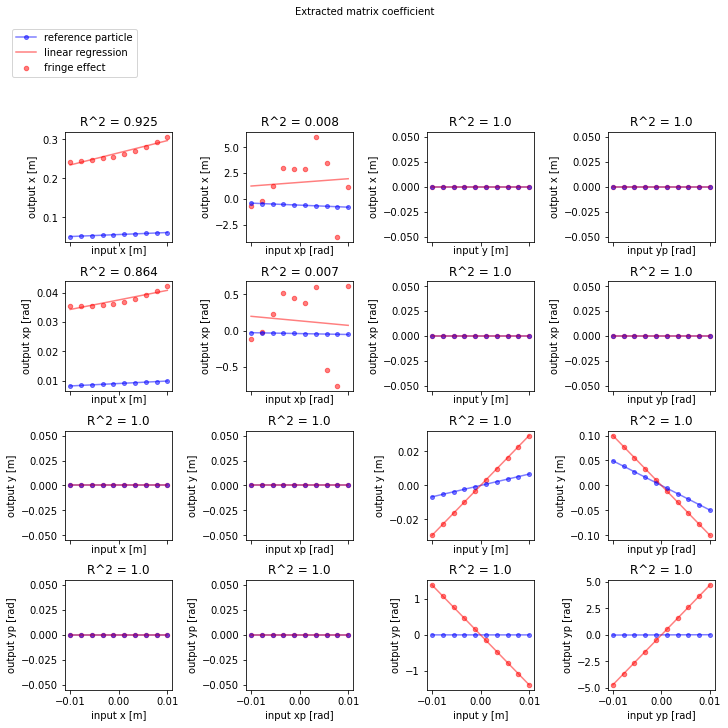

In [16]:
fig, ax = plt.subplots(4, 4, figsize=(10,10), constrained_layout=True, sharex=True, squeeze=False)
#squeeze argument if I only have one sublot instead of 6x6 filled

xvalues = np.linspace(-values_lim, values_lim, values_no)# This centers the linspace around the position of the beam
yvalues = np.zeros(values_no)

# Reference Matrix
twiss = madx.twiss(beta0 = "bumped",
                   rmatrix=True).dframe()
matExtractedRef = get_matrix_from_twiss(twiss)

for k in range (4):
    vectorOld = np.array([[0.], [0.], [0.], [0.], [0.], [0.]])
    vectorNew = np.array([0.,0.,0.,0.,0.,0.])
    for j in range (4):
        for i in range (0,values_no):
            vectorOld[k]=xvalues[i]+initialValues[k]
            vectorNew = np.dot(matExtractedRef,vectorOld) # Matrix multiplication 
            yvalues[i]=vectorNew[j]
        ax[j,k].plot(xvalues, yvalues, marker = 'o', markersize=4, color = 'b', alpha=0.5, label="reference particle")

        yvalues = np.zeros(values_no)
        for i in range (0,values_no): # Change the twiss inputs around the reference particle
            vectorOld[k]=xvalues[i]+initialValues[k]

            if k==0:
                twiss = madx.twiss(beta0 = "bumped",
                                   x=xvalues[i]+initialValues[0], px=initialValues[1],
                                   y=0, py=0,
                                   rmatrix=True).dframe()
            if k==1:
                twiss = madx.twiss(beta0 = "bumped",
                                   x=initialValues[0], px=xvalues[i]+initialValues[1],
                                   y=0, py=0,
                                   rmatrix=True).dframe()     
            if k==2:
                twiss = madx.twiss(beta0 = "bumped",
                                   x=initialValues[0], px=initialValues[1],
                                   y=0, py=0,
                                   rmatrix=True).dframe()
            if k==3:
                twiss = madx.twiss(beta0 = "bumped",
                                   x=initialValues[0], px=initialValues[1],
                                   y=0, py=0,
                                   rmatrix=True).dframe()
            
            matExtracted = get_matrix_from_twiss(twiss)

            vectorNew = np.dot(matExtracted,vectorOld) # Matrix multiplication    
            yvalues[i]=vectorNew[j]
        ax[j,k].scatter(xvalues, yvalues, marker = 'o', s=20, color = 'r', alpha=0.5, label="fringe effect")
        ax[j,k].set_xlabel("input "+var_names[k]+" "+var_units[k])
        ax[j,k].set_ylabel("output "+var_names[j]+" "+var_units[j])
        
        #Linear regression
        xlin = xvalues.reshape((-1,1))
        model = LinearRegression().fit(xlin,yvalues)
        r_sq = model.score(xlin, yvalues)
        y_pred = model.predict(xlin)
        ax[j,k].plot(xvalues, y_pred, color = 'r', alpha=0.5, label="linear regression")
        ax[j,k].title.set_text('R^2 = '+str(round(r_sq, 3)))

fig.suptitle("Extracted matrix coefficient", fontsize=10)
ax[0,0].legend(loc=(-0.5, 1.5),fontsize=10)
fig.show()